In [ ]:
# Import pandasw
import pandas as pd
import math
from matplotlib import pyplot as plt
import random
from copy import deepcopy

In [ ]:
# Constants
COLORS = ["red", "orange", "yellow", "green", "blue", "indigo", "purple"]

In [ ]:
mainData = pd.read_csv("data/kmeans.csv", index_col=None, header=0, engine='python')
mainData = mainData.values.tolist()

In [ ]:
class Point:
    def __init__(self, p_x, p_y, p_classifier=None):
        self.x = p_x
        self.y = p_y
        self.classifier = p_classifier # None, 1+
    
    def __str__(self):
        return "x: " + str(self.x) + ", y: " + str(self.y) + ", classifier: " + str(self.classifier)
    
    def setClassifier(self, p_classifier):
        assert type(p_classifier) == int, "Int is required!"
        self.classifier = p_classifier

class Centroid:
    def __init__(self, p_x, p_y, p_classifier=None):
        self.x = p_x
        self.y = p_y
        self.classifier = p_classifier # None, 1+
        self.pointsList = []
    
    def __str__(self):
        return "x: " + str(self.x) + ", y: " + str(self.y) + ", classifier: " + str(self.classifier)
    
    def __len__(self):
        return len(self.pointsList)
    
    def setClassifier(self, p_classifier):
        assert type(p_classifier) == int, "Int is required!"
        self.classifier = p_classifier
    
    def addPoint(self, p_point):
        assert type(p_point) == Point, "Point is required!"
        self.pointsList.append(p_point)
    
    def resetPoints(self):
        self.pointsList.clear()


In [ ]:
def GeneratePointsList(p_dataList):
    pList = []
    for i, data in enumerate(p_dataList):
        p = Point(data[0], data[1])
        pList.append(p)
    
    return pList

def EuclideanDistance(p_xPoint, p_yPoint):
    a = math.pow(p_xPoint[0] - p_yPoint[0], 2)
    b = math.pow(p_xPoint[1] - p_yPoint[1], 2)
    return math.sqrt(a + b)

def EuclideanDistancePointCentroid(p_point, p_centroid):
    a = math.pow(p_point.x - p_centroid.x, 2)
    b = math.pow(p_point.y - p_centroid.y, 2)
    return math.sqrt(a + b)


def GenerateZeroMatrix(p_size):
    dMatrix = [[0 for i in range(p_size)] for i in range(p_size)]
    return dMatrix

def GenerateDistanceMatrix(p_dataArray):
    dataArrayLength = len(p_dataArray)
    dMatrix = GenerateZeroMatrix(dataArrayLength)
    for row in range(dataArrayLength):
        for col in range(row, dataArrayLength):
            d = EuclideanDistance(p_dataArray[row], p_dataArray[col])
            dMatrix[row][col] = d
            dMatrix[col][row] = d
    return dMatrix

def GenerateDistanceMatrix2(p_dataArray):
    dMatrix = []
    for ci, i in enumerate(p_dataArray):
        dMatrix.append([])
        for cj, j in enumerate(p_dataArray):
            d = EuclideanDistance(i, j)
            dMatrix[ci].append(d)
    return dMatrix

def ValidateTwins(p_m1, p_m2):
    if len(p_m1) != len(p_m2):
        return False

    length = len(p_m1)

    for i in range(length):
        for j in range(length):
            if p_m1[i][j] != p_m2[i][j]:
                return False
    return True

def PrintDistanceMatrix(p_distanceMatrix):
    print("     ",end="")
    for i in range(len(p_distanceMatrix)):
        print(f"{i:<8}", end=" ")
    print()

    for index, row in enumerate(p_distanceMatrix):
        print(f"{index}", end="    ")
        for i in row:
            print(f"{i:<8.3f}", end=" ")
        print()
    return

def plotData(p_pointsList, p_centroidList=[], p_xTitle="f1", p_yTitle="f2"):
    plt.rcParams["figure.figsize"] = [10, 8]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot()

    for ci, i, in enumerate(p_pointsList):
        mycolor = COLORS[i.classifier] if i.classifier is not None else "#000000"
        ax.scatter(i.x, i.y, c=mycolor, s=150, linewidths=1, edgecolors='#8D99AE')
    
    for ci, i, in enumerate(p_centroidList):
        mycolor = COLORS[i.classifier] if i.classifier is not None else "#000000"
        ax.scatter(i.x, i.y, c=mycolor, s=50, linewidths=2, edgecolors='#8D99AE')


    plt.xlim(0, 90)
    plt.ylim(0, 90)
    plt.xlabel(p_xTitle)
    plt.ylabel(p_yTitle)
    plt.title("Scatter Plot")
    plt.show()
    return

In [27]:
def CreateCentroids(p_pointsList, p_k):
    plLength = len(p_pointsList)
    counter = 0

    randomPointsList = []

    while counter < p_k:
        rNum = random.randint(0, plLength-1)
        rPoint = p_pointsList[rNum]

        if rPoint not in randomPointsList:
            randomPointsList.append(rPoint)
            counter += 1
        else:
            print("reshuffle")
    
    centroidList = []

    for i, data in enumerate(randomPointsList):
        data.setClassifier(i)
        c = Centroid(data.x, data.y, data.classifier)
        centroidList.append(c)
    
    return centroidList

def MinimumDistance(p_eDistanceList):
    count = -1
    distance = 9999999 #maxsize

    for i, data in enumerate(p_eDistanceList):
        if data < distance:
            distance = data
            count = i
    
    return count
    
def ResetCentroidList(p_centroidList):
    for i in p_centroidList:
        i.resetPoints()

def RepositionCentroidList(p_centroidList):
    for i in p_centroidList:
        totalX = 0
        totalY = 0
        count = 0
        for j in i.pointsList:
            totalX += j.x
            totalY += j.y
            count += 1
        i.x = totalX / count
        i.y = totalY / count

def CentroidData(p_centroidList):
    for data in p_centroidList:
        print("Centroid Classifier", "#" + str(data.classifier), "[" + COLORS[data.classifier].upper() + "]")
        print("  Size:", len(data))
        print("  X Position: {:.4f} Y Position: {:.4f}".format(data.x,data.y))
        print()

def kmeans(p_pointList, p_k=1):
    classifierModified = True
    f_pointsList = deepcopy(p_pointList)
    f_centroidsList = CreateCentroids(f_pointsList, p_k)
    print()

    counter = 0
    while classifierModified:
        counter += 1
        classifierModified = False
        ResetCentroidList(f_centroidsList)

        for i in f_pointsList: # main loop
            edistanceList = []
            for j in f_centroidsList: # loop through centroids
                dist = EuclideanDistancePointCentroid(i, j)
                edistanceList.append(dist)
            
            verdict = MinimumDistance(edistanceList)
            if verdict != i.classifier:
                if classifierModified == False:
                    classifierModified = True

                i.setClassifier(verdict)
            
            f_centroidsList[i.classifier].addPoint(i)
        
        RepositionCentroidList(f_centroidsList)
    plotData(f_pointsList)
    CentroidData(f_centroidsList)


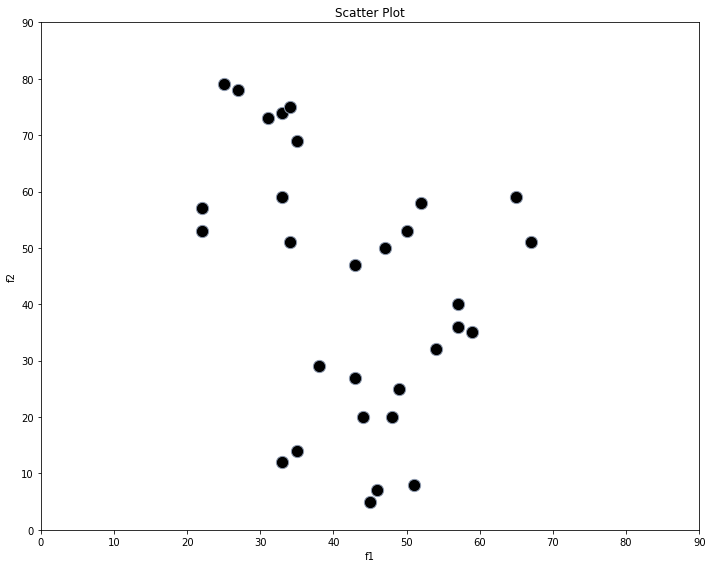

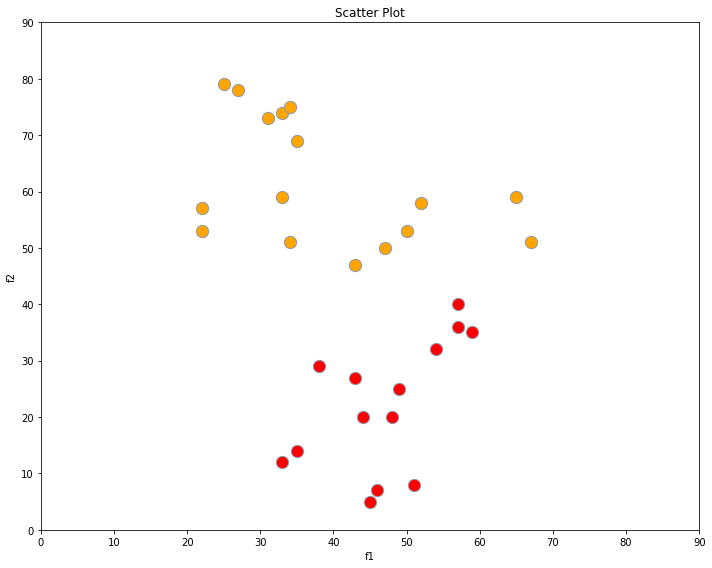

Centroid Classifier #0 [RED]
  Size: 14
  X Position: 47.0714 Y Position: 22.1429

Centroid Classifier #1 [ORANGE]
  Size: 16
  X Position: 38.7500 Y Position: 61.6250



In [28]:
pointsList = GeneratePointsList(mainData)
plotData(pointsList) 
kmeans(pointsList,2)

In [29]:
# 1) Create a list of points to store the points for looping
# 2) Pick a random number and pick the point corresponding to the random number
# 3) Mark the point as the specified centroid class
# 4) Generate a centroid and get the points coordinates
# 5) Do step 2-4 until you reach the k-value
# 6) Now loop through each point and evaluate the Euclidean Distance between the point and each centroid. Pick the closests centroid and mark the class type for each point
# 7) Once every point has been searched, evaluate the average of each centroid/class, and adjust the average scores onto the centroid
# 8) Redo the process again.

# 9) Until you reached a point where no point has changed the class, then we say this is done
# 10) Graph it out and done.